In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import pulp

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

## Initial Settings.

There are 27 meetings, and the current strength of the club was 26 members. There are different roles that a member can play in each meeting, such as that of a ‘Speech Evaluator’, ‘Speaker’ or ‘Table Topics master’. To successfully conduct a meeting, 17 roles have to be assigned to the different members present.

1. There are 26 members.
2. There are 27 days.
3. There are 17 roles.

In [2]:
members = range(1,27)
days = range(1,28)
roles = range(1,18)

### Step 1: Instantiate a problem class.

Objective: to maximize allocations of everyone

In [3]:
model = pulp.LpProblem(name='maximize-allocations-in-toastmasters', sense=pulp.const.LpMaximize)


### Step 2: Model the decision variables.

Decision variable is the one to be included inside cost function.

In this case, x is the indicator for allocating which role to which member in which day.

In [4]:
# defining the variables
x = pulp.LpVariable.dicts(name='x', indexs=(members,days,roles), 
                          lowBound=0, upBound=1, cat='Integer')

In [5]:
x

{1: {1: {1: x_1_1_1,
   2: x_1_1_2,
   3: x_1_1_3,
   4: x_1_1_4,
   5: x_1_1_5,
   6: x_1_1_6,
   7: x_1_1_7,
   8: x_1_1_8,
   9: x_1_1_9,
   10: x_1_1_10,
   11: x_1_1_11,
   12: x_1_1_12,
   13: x_1_1_13,
   14: x_1_1_14,
   15: x_1_1_15,
   16: x_1_1_16,
   17: x_1_1_17},
  2: {1: x_1_2_1,
   2: x_1_2_2,
   3: x_1_2_3,
   4: x_1_2_4,
   5: x_1_2_5,
   6: x_1_2_6,
   7: x_1_2_7,
   8: x_1_2_8,
   9: x_1_2_9,
   10: x_1_2_10,
   11: x_1_2_11,
   12: x_1_2_12,
   13: x_1_2_13,
   14: x_1_2_14,
   15: x_1_2_15,
   16: x_1_2_16,
   17: x_1_2_17},
  3: {1: x_1_3_1,
   2: x_1_3_2,
   3: x_1_3_3,
   4: x_1_3_4,
   5: x_1_3_5,
   6: x_1_3_6,
   7: x_1_3_7,
   8: x_1_3_8,
   9: x_1_3_9,
   10: x_1_3_10,
   11: x_1_3_11,
   12: x_1_3_12,
   13: x_1_3_13,
   14: x_1_3_14,
   15: x_1_3_15,
   16: x_1_3_16,
   17: x_1_3_17},
  4: {1: x_1_4_1,
   2: x_1_4_2,
   3: x_1_4_3,
   4: x_1_4_4,
   5: x_1_4_5,
   6: x_1_4_6,
   7: x_1_4_7,
   8: x_1_4_8,
   9: x_1_4_9,
   10: x_1_4_10,
   11: x_1_4_11,


### Step 3: Add objective function.

In [6]:
model += pulp.lpSum(x[member][day][role] for member in members for day in days for role in roles)

### Step 4: Add constraint.

<b>Basic constraint</b>

1. Each meeting (day) only has 17 roles that can be assigned.
2. For this to be a fair model, every member has to have the opportunity to perform each role at least once during the season.
3. Each member can perform only one role in a meeting.
4. Every role in the meeting must be assigned.

<b>Extra constraint</b>

5. Assign a role to a member on a specific meeting due to some personal reasons. Example: if m=1, d=2, r=3.
6. No member is sitting idle for 3 consecutive meetings.

In [7]:
# Each meeting (day) only has 17 roles that can be assigned.

for day in days:
    
    model += pulp.lpSum(x[member][day][role] for member in members for role in roles) == 17

In [8]:
# For this to be a fair model, every member has to have the opportunity to perform each role 
# at least once during the season.

for member in members:
    for role in roles:
        
        model += pulp.lpSum(x[member][day][role] for day in days) >= 1

In [9]:
# Each member can perform only one role in a meeting (day).

for member in members:
    for day in days:
        
        model += pulp.lpSum(x[member][day][role] for role in roles) <= 1

In [10]:
# Every role in the meeting must be assigned.

for day in days:
    for role in roles:
    
        model += pulp.lpSum(x[member][day][role] for member in members) == 1

In [11]:
# Assign a role to a member on a specific meeting due to some personal reasons. 
# Example: if m=1, d=2, r=3.

model += pulp.lpSum(x[1][2][3]) == 1

In [12]:
# No member is sitting idle for 3 consecutive meetings.

for member in members:
    for day in days:
        
        if ((day>=2) & (day<=26)):
            model += pulp.lpSum(x[member][day-1][role]+x[member][day][role]+x[member][day+1][role] for role in roles)>= 1
            

### Step 5: Solve linear equation.

In [13]:
model.solve()
pulp.LpStatus[model.status]

'Optimal'

In [14]:
total_cost = pulp.value(model.objective)

print(f'The optimized allocation is {total_cost}.')

The optimized allocation is 459.0.


In [15]:
person_list = []
day_list = []
role_list = []
value_list = []

for vi in model.variables():
    person = int(vi.name.split("_")[1])
    day = int(vi.name.split("_")[2])
    role = int(vi.name.split("_")[3])
    
    person_list.append(person)
    day_list.append(day)
    role_list.append(role)
    value_list.append(vi.varValue)
    
data = {'Person':person_list, 'Day':day_list, 'Role':role_list, 'Value':value_list} 

df = pd.DataFrame(data)

In [16]:
detailed_roles = [
'Ah Counter', 
'Grammarian',
'Timer', 
'Toastmaster', 
'Meeting speaker 1',
'Meeting speaker 2',
'Meeting speaker 3',
'meeting speaker 4',
'Speech Evaluator 1',
'Speech Evaluator 2',
'Speech Evaluator 3',
'Speech Evaluator 4',
'General evaluator', 
'Table topic master', 
'Table topic evalauator 1',
'Table topic evalauator 2',
'Harkmaster' ]

detailed_persons = [
'Member 1',
'Member 2',
'Member 3',
'Member 4',
'Member 5',
'Member 6',
'Member 7',
'Member 8',
'Member 9',
'Member 10',
'Member 11',
'Member 12',
'Member 13',
'Member 14',
'Member 15',
'Member 16',
'Member 17',
'Member 18',
'Member 19',
'Member 20',
'Member 21',
'Member 22',
'Member 23',
'Member 24',
'Member 25',
'Member 26'
]

In [17]:
role_dict = {}
for i in enumerate(detailed_roles):
    role_dict[i[0] + 1] = i[1]
    
person_dict = {}
for i in enumerate(detailed_persons):
    person_dict[i[0] + 1] = i[1]

In [18]:
df['Name'] = df['Person'].apply(lambda x:person_dict[int(x)])
df['Assignment'] = df['Role'].apply(lambda x:role_dict[int(x)])

### To see which member is assigned in which day.

In [19]:
def visualize(df, title, xlabel, ylabel):
    
    fig, ax = plt.subplots(figsize=(15,15))

    plt.rcParams.update({'font.size': 14})    
    plt.rcParams['patch.linewidth'] = 0
    plt.rcParams['patch.edgecolor'] = 'none'
    legend_colors = []
    legend_names = []

    sns.heatmap(df, cmap='Blues', cbar=False, annot=True, ax=ax)

    ax.set_title(f'{title}', loc='center',fontsize=20) 
    ax.set_xlabel(f'{xlabel}',fontsize=15)
    ax.set_ylabel(f'{ylabel}',fontsize=15)
    
    plt.show()

In [20]:
member_meeting_day = pd.pivot_table(df[['Name', 'Day', 'Value']], index='Name', 
                                     columns='Day', aggfunc='sum', margins=True)

member_meeting_day.rename(columns={'Value':'Day'}, inplace=True)

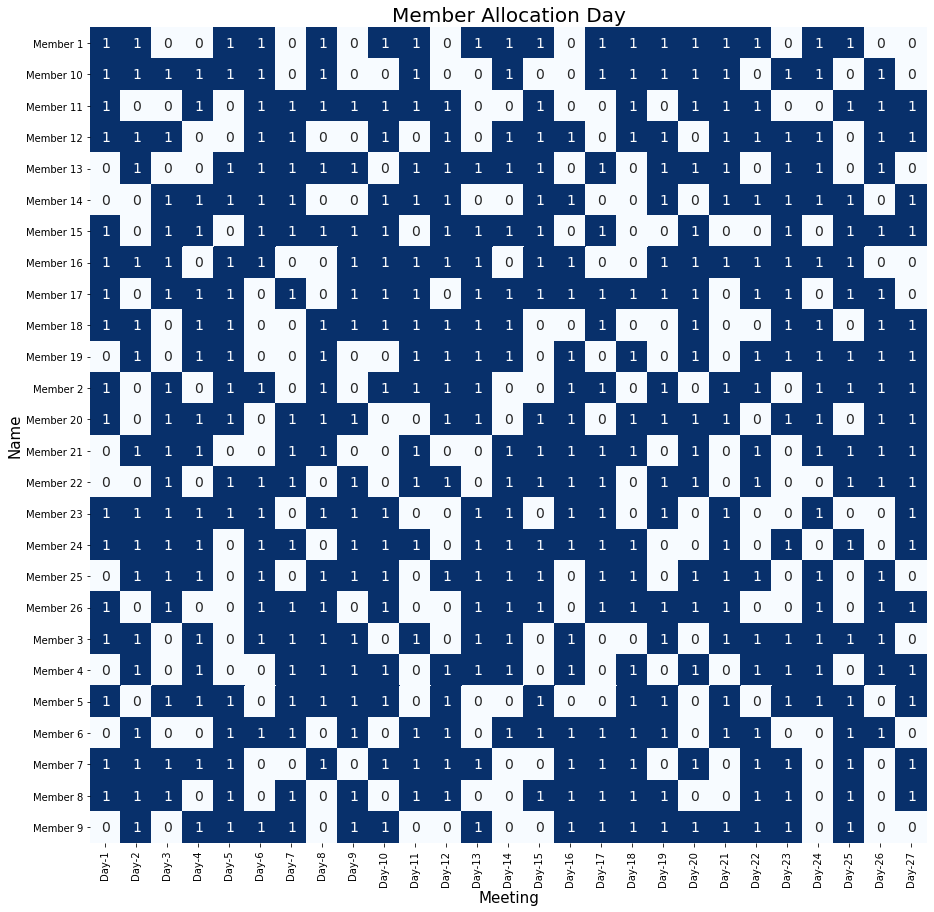

In [21]:
member_meeting_day_viz = pd.pivot_table(df[['Name', 'Day', 'Value']], index='Name', 
                                     columns='Day', aggfunc='sum', margins=False)

member_meeting_day_viz.rename(columns={'Value':'Day'}, inplace=True)

TITLE = 'Member Allocation Day'
XLABEL = 'Meeting'
YLABEL = 'Name'

visualize(df=member_meeting_day_viz, title=TITLE, xlabel=XLABEL, ylabel=YLABEL)

In [22]:
df_role = df[df['Value']==1]

member_role = pd.pivot_table(df_role[['Name', 'Day', 'Role']], index='Name', columns='Day', 
                             fill_value=0, aggfunc='sum', margins=True)

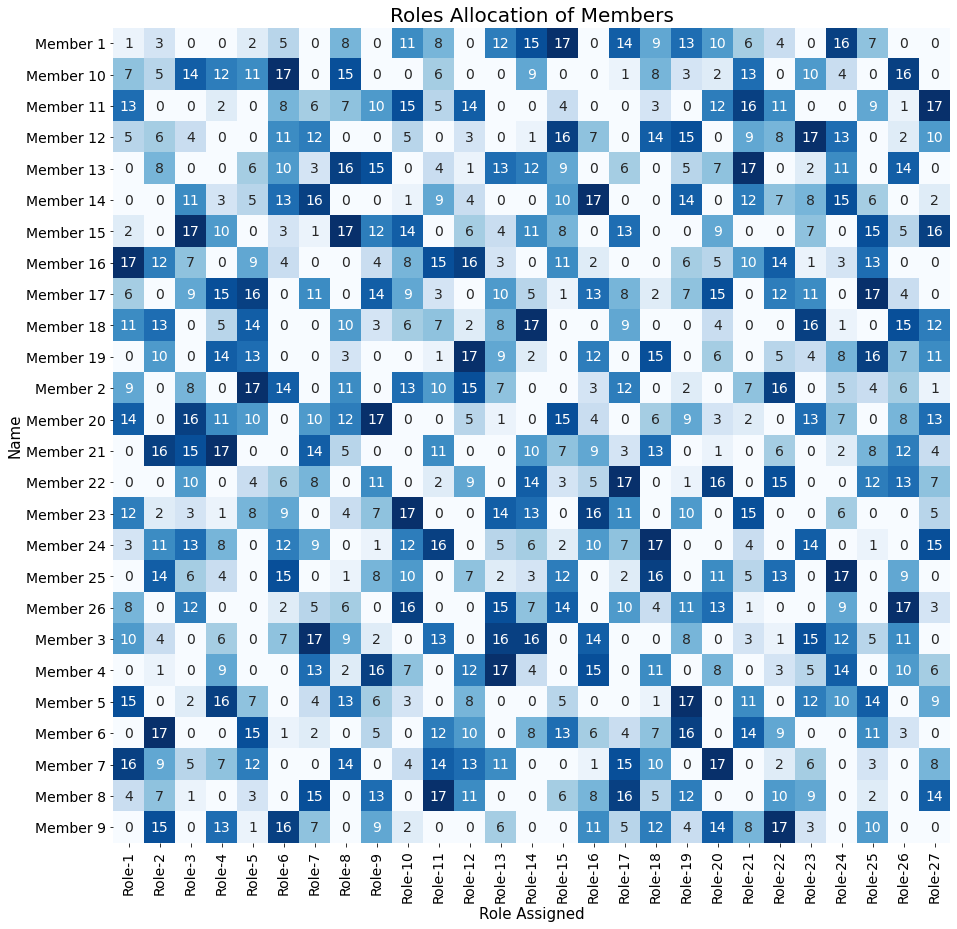

In [23]:
df_role = df[df['Value']==1]

member_role_viz = pd.pivot_table(df_role[['Name', 'Day', 'Role']], index='Name', columns='Day', 
                             fill_value=0, aggfunc='sum', margins=False)

TITLE = 'Roles Allocation of Members'
XLABEL = 'Role Assigned'
YLABEL = 'Name'

visualize(df=member_role_viz, title=TITLE, xlabel=XLABEL, ylabel=YLABEL)

---

## Reference

https://towardsdatascience.com/roster-optimization-using-python-85b26d58e806